In [29]:
import pandas as pd
from sklearn import feature_selection, model_selection, metrics
import matplotlib.pyplot as plt
import xgboost as xgb

In [32]:
enh_df = pd.read_csv("enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
pro_df = pd.read_csv("pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
ABC_rep_df = pd.read_csv("EPCrisprBenchmark_ensemble_data_GRCh38.K562_ActivityOnly_features_NAfilled.tsv", sep="\t")

In [33]:
# check we didn't fuck up the order of EPI candidates listed in any of the output files
assert((ABC_rep_df["chrom"] == enh_df["chrom"]).all())
assert((ABC_rep_df["chromStart"] == enh_df["start"]).all())
assert((ABC_rep_df["chromEnd"] == enh_df["end"]).all())

assert((ABC_rep_df["chrTSS"] == pro_df["chrom"]).all())
assert((ABC_rep_df["startTSS"] == pro_df["start"]).all())
assert((ABC_rep_df["endTSS"] == pro_df["end"]).all())

In [34]:
all_df = pd.concat([ABC_rep_df[['dataset', 'chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS', 'startTSS', 'endTSS']],
                    enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1), 
                    pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1),
                    ABC_rep_df[["ABC.Score", "distanceToTSS", "Regulated"]]
                    ], axis = 1)
all_df

,dataset,chrom,chromStart,chromEnd,name,chrTSS,startTSS,endTSS,enh_DNase.counts.RPKM,enh_H3K4me3.counts.RPKM,...,enh_H3K27ac.counts.RPKM,enh_CAGE.counts.RPKM,pro_DNase.counts.RPKM,pro_H3K4me3.counts.RPKM,pro_CTCF.counts.RPKM,pro_H3K27ac.counts.RPKM,pro_CAGE.counts.RPKM,ABC.Score,distanceToTSS,Regulated
0,FlowFISH_K562,chr1,3774714,3775214,CEP104|chr1:3691278-3691778:*,chr1,3857213,3857214,30.538651,1.065218,...,3.082946,0.144001,1840.066697,958.696037,541.802152,169.703449,1908.011524,0.074041,81671.5,True
1,FlowFISH_K562,chr1,3774714,3775214,LRRC47|chr1:3691278-3691778:*,chr1,3796503,3796504,30.538651,1.065218,...,3.082946,0.144001,774.764925,461.594388,169.313173,70.709770,4356.026310,0.103963,20942.5,True
2,FlowFISH_K562,chr1,3774714,3775214,SMIM1|chr1:3691278-3691778:*,chr1,3772761,3772762,30.538651,1.065218,...,3.082946,0.144001,225.973103,532.608909,101.587904,127.277586,2844.017178,0.262355,2775.5,True
3,FlowFISH_K562,chr10,125816658,125816735,UROS|chr10:127505227-127505304:*,chr10,125823284,125823285,47.374695,2.766800,...,2.387603,20.571553,742.483053,426.087128,0.000000,197.987357,108.000652,0.201618,6586.0,True
4,FlowFISH_K562,chr11,3261795,3262295,HBE1|chr11:3283025-3283525:*,chr11,5505651,5505652,0.645637,0.142029,...,0.197987,0.000000,225.973103,355.072606,67.725269,127.277586,2340.014134,0.000000,2008268.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10406,TAPseq,chr8,125528738,125529164,NSMCE2|chr8:125528738-125529164:.,chr8,125091679,125091680,1.667139,0.666803,...,0.962715,0.000000,581.073694,674.637952,203.175807,70.709770,324.001957,0.000196,437158.0,False
10407,TAPseq,chr8,125544507,125545059,NSMCE2|chr8:125544507-125545059:.,chr8,125091679,125091680,0.350890,0.192974,...,0.435531,0.000000,581.073694,674.637952,203.175807,70.709770,324.001957,0.000000,452943.0,False
10408,TAPseq,chr8,125664274,125664878,NSMCE2|chr8:125664274-125664878:.,chr8,125091679,125091680,3.527489,0.470295,...,1.451658,0.000000,581.073694,674.637952,203.175807,70.709770,324.001957,0.003620,572780.0,False
10409,TAPseq,chr8,125694248,125694539,NSMCE2|chr8:125694248-125694539:.,chr8,125091679,125091680,0.000000,0.122018,...,0.340184,0.000000,581.073694,674.637952,203.175807,70.709770,324.001957,0.000000,602553.5,False


In [35]:
all_df.isna().any()

dataset                    False
chrom                      False
chromStart                 False
chromEnd                   False
name                       False
chrTSS                     False
startTSS                   False
endTSS                     False
enh_DNase.counts.RPKM      False
enh_H3K4me3.counts.RPKM    False
enh_CTCF.counts.RPKM       False
enh_H3K27ac.counts.RPKM    False
enh_CAGE.counts.RPKM       False
pro_DNase.counts.RPKM      False
pro_H3K4me3.counts.RPKM    False
pro_CTCF.counts.RPKM       False
pro_H3K27ac.counts.RPKM    False
pro_CAGE.counts.RPKM       False
ABC.Score                  False
distanceToTSS              False
Regulated                  False
dtype: bool

In [36]:
feature_columns = all_df.columns[8:-1]
label_column = all_df.columns[-1]

print(feature_columns)

feature_MI = feature_selection.mutual_info_classif(all_df[feature_columns], all_df[label_column])

MI_results = list(zip(feature_columns, feature_MI))
MI_results.sort(key = lambda x: x[1], reverse=True)
print(MI_results)

Index(['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM', 'ABC.Score',
       'distanceToTSS'],
      dtype='object')
[('ABC.Score', 0.08802456664409286), ('distanceToTSS', 0.06575768369185697), ('enh_DNase.counts.RPKM', 0.02742013373967489), ('enh_H3K27ac.counts.RPKM', 0.026966045760556057), ('enh_CTCF.counts.RPKM', 0.014365228403052432), ('pro_CAGE.counts.RPKM', 0.01168521497398145), ('pro_DNase.counts.RPKM', 0.011122998528238615), ('enh_H3K4me3.counts.RPKM', 0.0107647607873127), ('pro_H3K4me3.counts.RPKM', 0.007613888429780946), ('pro_H3K27ac.counts.RPKM', 0.006655178785495819), ('pro_CTCF.counts.RPKM', 0.005743933710426141), ('enh_CAGE.counts.RPKM', 0.005426124152112077)]


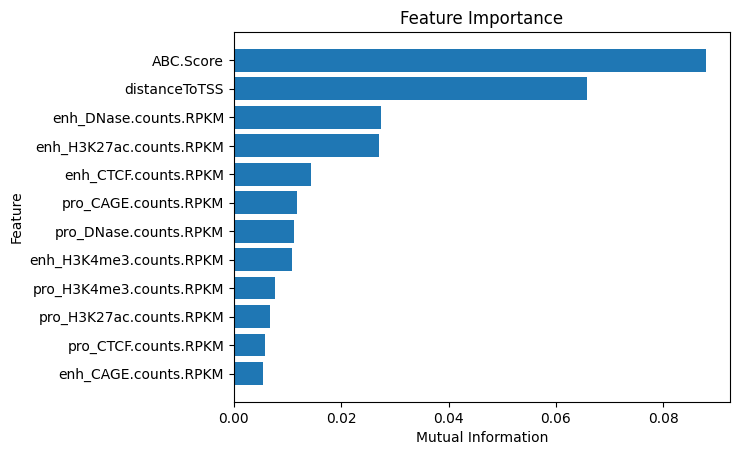

In [37]:
feature_columns, feature_MI = zip(*MI_results)
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.xlabel("Mutual Information")
plt.barh(feature_columns, feature_MI)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.show()

# Performance of Model using All Features

0.697150843055712


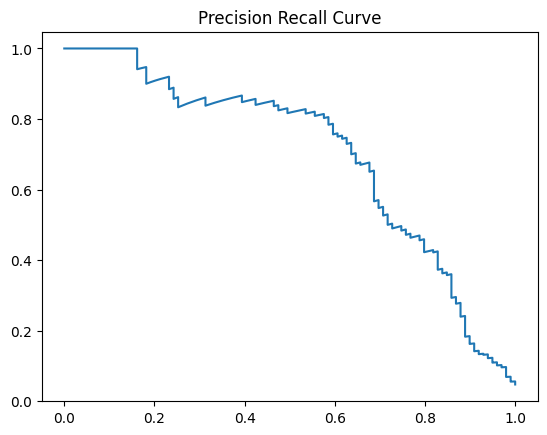

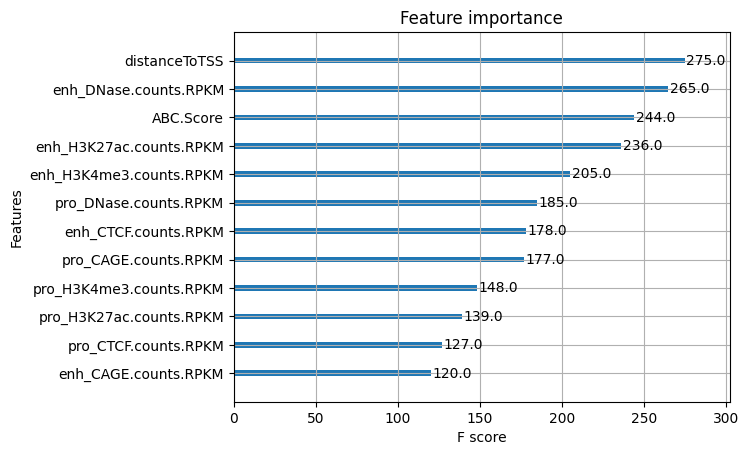

In [51]:
X = all_df.iloc[:, 8:-1]
y = all_df.iloc[:, -1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=314)

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
plt.show()

# Using Distance Only, ABC Only, Distance + ABC only

0.4311840363194449


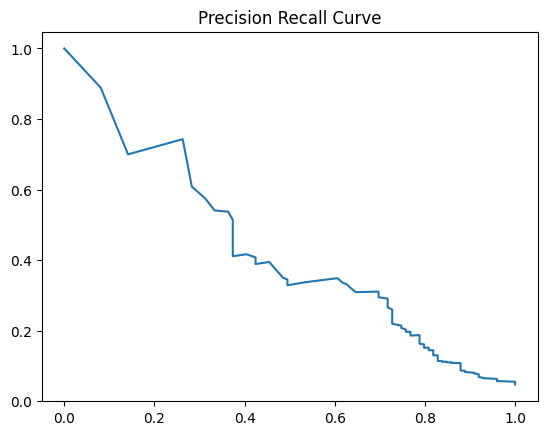

In [52]:
# Distance Only

X = all_df[["distanceToTSS"]].to_numpy()
y = all_df["Regulated"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=314)

clf = xgb.XGBClassifier().fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

0.531406901756661


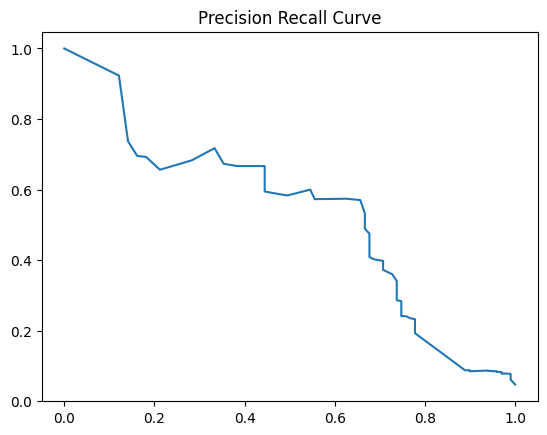

In [53]:
# ABC Only

X = all_df[["ABC.Score"]].to_numpy()
y = all_df["Regulated"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=314)

clf = xgb.XGBClassifier().fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr) # We obtain similar performance as the original ABC paper

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

0.5164571486907348


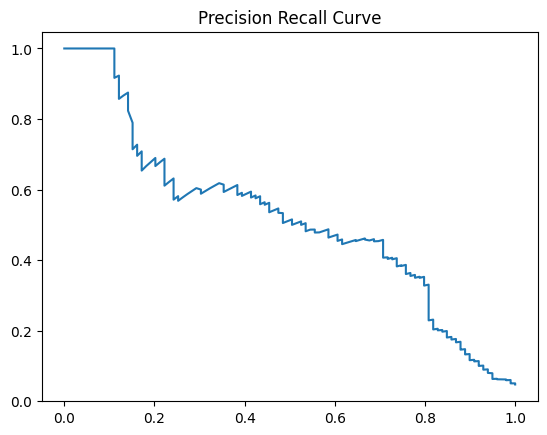

In [55]:
# ABC + Distance

X = all_df[["ABC.Score", "distanceToTSS"]].to_numpy()
y = all_df["Regulated"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=314)

clf = xgb.XGBClassifier().fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr) # We obtain similar performance as the original ABC paper

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

0.3033336492130209


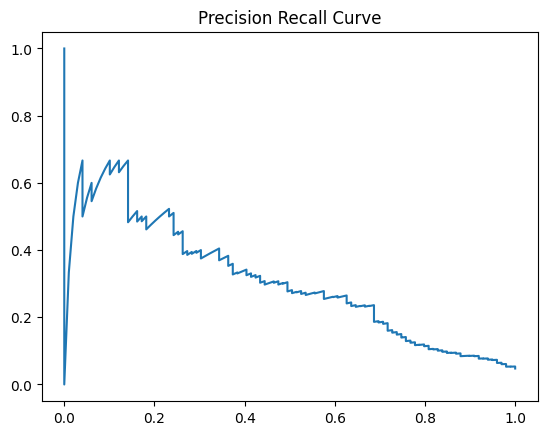

In [57]:
X = all_df[['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM']].to_numpy()
y = all_df["Regulated"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=314)

clf = xgb.XGBClassifier().fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr) # We obtain similar performance as the original ABC paper

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

# ABC Score + Distance + DNase + H3K27ac
since DNase and H3K27ac are used in calculation of ABC score, and it appears to be an important feature, we might as well include it

0.7055802574685792


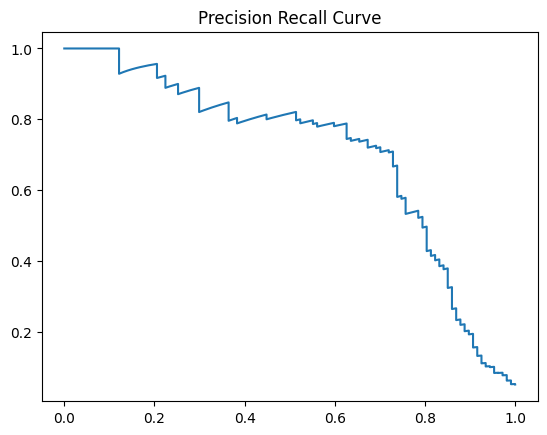

In [58]:
# ABC + Distance

X = all_df[["ABC.Score", "distanceToTSS", "enh_DNase.counts.RPKM", "enh_H3K27ac.counts.RPKM", "pro_H3K27ac.counts.RPKM", "pro_DNase.counts.RPKM"]].to_numpy()
y = all_df["Regulated"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

clf = xgb.XGBClassifier().fit(X_train, y_train)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print(aupr) # We obtain similar performance as the original ABC paper

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

# Conclusions
In terms of Mutual Information (Correlation betweeen Continuous feature and Binary label)
- Distance to transcription start site is the most informative feature in determining EPI (better than any other seq's alone)
- However, by itself its performance is quite poor
- ABC Score is the only epigenetic feature that beats out Distance alone 

Distance + ABC Score yields moderately good model performance
Distance + ABC Score + Epigenetic features used to calculate ABC Score yields very good model performance
- This is good because it means we only two seq's experiments (DNase and H3K27ac)
  - In practise, ABC Score can be calculated with DNase only, so even DNase by itself could be sufficient

We find rapidly diminishing returns upon naively adding new epigenetic features
- Looking at the Mutual Information of each epigenetic feature, it is quite dismal
- Further, all the epigenetic features put together fail to outperform distance alone

I suspect that these features can still be useful, provided there is some other ABC-like model to transform the epigenetic feautures in a sensible (domain knowledge needed) way. 
  - For example, CTCF can act as Enhancer in its own right but also is found near loop anchors which can be surprisingly far from interacting EP pairs 
  - As it stands, the CTCF feature in this benchmark is calculated by a simple overlap with the candidate pairs which may miss that nuance